<h1 align=center><font size = 5>Segmenting, Clustering and Comparing Neighborhoods from  New York City and London</font></h1>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [2]:
import os
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from time import sleep

import requests # library to handle requests
import json # librart to handle json files

# Matplotlib and associated plotting modules

from matplotlib import pyplot as plt
plt.style.use('ggplot')

import matplotlib.cm as cm
import matplotlib.colors as colors


# import k-means from clustering stage
from sklearn.cluster import KMeans

# import to encode categorized features
from sklearn import preprocessing

import folium # map rendering library

from unidecode import unidecode

from lxml import html

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>

## 1. Download and Explore Dataset

#### Load and explore the data

In [3]:
try:
    nyc_data = requests.get("https://cocl.us/new_york_dataset").json()
except Exception:
    with open('newyork_data.json', 'r') as json_data:
        nyc_data = json.load(json_data)
print('Data downloaded!')

Data downloaded!


All the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [4]:
neighborhoods_data = nyc_data['features']

Let's take a look at the first item in this list.

In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Transform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [6]:
# define the dataframe columns
column_names = ['borough', 'neighborhood', 'latitude', 'longitude'] 

# instantiate the dataframe
nyc_data = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [7]:
nyc_data

,borough,neighborhood,latitude,longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [8]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_data = nyc_data.append({'borough': borough,
                                'neighborhood': neighborhood_name,
                                'latitude': neighborhood_lat,
                                'longitude': neighborhood_lon
                                },
                               ignore_index=True
                               )

Quickly examine the resulting dataframe.

In [207]:
print(nyc_data.shape)
nyc_data.head()

(306, 5)


,borough,borough_encoded,neighborhood,latitude,longitude
0,Bronx,0,Wakefield,40.894705,-73.847201
1,Bronx,0,Co-op City,40.874294,-73.829939
2,Bronx,0,Eastchester,40.887556,-73.827806
3,Bronx,0,Fieldston,40.895437,-73.905643
4,Bronx,0,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(nyc_data['borough'].unique()),
        nyc_data.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Let's encode NYC's boroughs

In [11]:
region_encoder = preprocessing.LabelEncoder()
region_encoder.fit(nyc_data['borough'])
nyc_data.insert(1, 'borough_encoded', region_encoder.transform(nyc_data['borough']))
nyc_data.head()

,borough,borough_encoded,neighborhood,latitude,longitude
0,Bronx,0,Wakefield,40.894705,-73.847201
1,Bronx,0,Co-op City,40.874294,-73.829939
2,Bronx,0,Eastchester,40.887556,-73.827806
3,Bronx,0,Fieldston,40.895437,-73.905643
4,Bronx,0,Riverdale,40.890834,-73.912585


#### Use geopy library to get the latitude and longitude values of New York City.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [12]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geographical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [13]:
# create map of New York using latitude and longitude values
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=10)

num_borough = nyc_data['borough_encoded'].unique()
color_range = list(range(0, len(num_borough)))
colors_array = [cm.tab10(x + 1) for x in color_range]
cat_colors = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, borough, neighborhood, borough_encoded in zip(nyc_data['latitude'], nyc_data['longitude'], nyc_data['borough'], nyc_data['neighborhood'], nyc_data['borough_encoded']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=cat_colors[borough_encoded],
        fill=True,
        fill_color=cat_colors[borough_encoded],
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)
    
map_nyc

## 2. Explore Neighborhoods in Manhattan

#### Define Foursquare Credentials and Version

In [14]:
%load_ext dotenv
# Use find_dotenv to locate the file
%dotenv passwords.env

CLIENT_ID = os.getenv('CLIENT_ID') # your Foursquare ID
CLIENT_SECRET = os.getenv('CLIENT_SECRET') # your Foursquare Secret
VERSION = os.getenv('VERSION') # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + ('LOADED' if CLIENT_ID is not None else 'NOT LOADED'))
print('CLIENT_SECRET:' + ('LOADED' if CLIENT_SECRET is not None else 'NOT LOADED'))

Your credentails:
CLIENT_ID: LOADED
CLIENT_SECRET:LOADED


#### Let's create a function to repeat the same process to all the neighborhoods

In [15]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        sleep(1)
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
        'neighborhood', 
        'neighborhood_latitude', 
        'neighborhood_longitude', 
        'venue', 
        'venue_latitude', 
        'venue_longitude', 
        'venue_category'
        ]
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *nyc_venues*.

In [16]:
# type your answer here
nyc_venues = getNearbyVenues(names=nyc_data['neighborhood'],
                             latitudes=nyc_data['latitude'],
                             longitudes=nyc_data['longitude']
                             )
nyc_venues.head()

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


#### Let's check the size of the resulting dataframe

In [17]:
print(nyc_venues.shape)
nyc_venues.head()

(10133, 7)


,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
3,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


Let's check how many venues were returned for each neighborhood

In [18]:
nyc_venues.groupby('neighborhood').count().head()

,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
neighborhood,,,,,,
Allerton,31,31,31,31,31,31
Annadale,11,11,11,11,11,11
Arden Heights,5,5,5,5,5,5
Arlington,6,6,6,6,6,6
Arrochar,22,22,22,22,22,22


#### Let's find out how many unique categories can be curated from all the returned venues

In [19]:
print('There are {} uniques categories.'.format(len(nyc_venues['venue_category'].unique())))

There are 430 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [20]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['venue_category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['neighborhood'] = nyc_venues['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]

print(nyc_onehot.shape)
nyc_onehot.head()

(10133, 431)


,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North 

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [21]:
nyc_grouped = nyc_onehot.groupby('neighborhood').mean().reset_index()
print(nyc_grouped.shape)
nyc_grouped.head()

(302, 431)


,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North 

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [23]:
def top_venues_neighboorhood(num_venues, city_grouped):
    num_top_venues = num_venues

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['neighborhood'] = city_grouped['neighborhood']

    for ind in np.arange(city_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(city_grouped.iloc[ind, :], num_top_venues)
    
    return neighborhoods_venues_sorted

In [24]:
neighborhoods_venues_sorted = top_venues_neighboorhood(10, nyc_grouped)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(302, 11)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allerton,Pizza Place,Deli / Bodega,Discount Store,Supermarket,Spa,Chinese Restaurant,Gas Station,Playground,Bakery,Pharmacy
1,Annadale,Pizza Place,American Restaurant,Food,Train Station,Restaurant,Dance Studio,Park,Deli / Bodega,Diner,Farm
2,Arden Heights,Deli / Bodega,Pharmacy,Coffee Shop,Bus Stop,Pizza Place,Fish & Chips Shop,Factory,Falafel Restaurant,Farm,Farmers Market
3,Arlington,Deli / Bodega,Coffee Shop,Bus Stop,Home Service,Boat or Ferry,Grocery Store,Flea Market,Falafel Restaurant,Farm,Farmers Market
4,Arrochar,Bus Stop,Deli / Bodega,Italian Restaurant,Beach,Hotel,Middle Eastern Restaurant,Outdoors & Recreation,Pharmacy,Liquor Store,Bagel Shop


<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters because there are 5 boroughs in NYC.

In [25]:
nyc_grouped.head()

,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North 

In [26]:
# set number of clusters
kclusters = 5
nyc_grouped_clustering = nyc_grouped.drop('neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 2, 2, 1, 1, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'cluster_labels', kmeans.labels_)

nyc_merged = nyc_data.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood')

print(nyc_merged.shape)
nyc_merged.head() # check the last columns!

(306, 16)


,borough,borough_encoded,neighborhood,latitude,longitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,0,Wakefield,40.894705,-73.847201,2,Pharmacy,Gas Station,Pizza Place,Sandwich Place,Laundromat,Ice Cream Shop,Donut Shop,Dessert Shop,Deli / Bodega,Fountain
1,Bronx,0,Co-op City,40.874294,-73.829939,1,Bus Station,Accessories Store,Pizza Place,Grocery Store,Fast Food Restaurant,Chinese Restaurant,Park,Bar,Bagel Shop,Trail
2,Bronx,0,Eastchester,40.887556,-73.827806,2,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Convenience Store,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Automotive Shop,Bowling Alley
3,Bronx,0,Fieldston,40.895437,-73.905643,1,River,Plaza,Medical Supply Store,Yoga Studio,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
4,Bronx,0,Riverdale,40.890834,-73.912585,1,Park,Playground,Gym,Bus Station,Plaza,Bank,Food Truck,Home Service,Moving Target,Field


Finally, let's visualize the resulting clusters

In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
color_range = list(range(0, kclusters))
colors_array = [cm.tab10(x) for x in color_range]
cat_colors = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['latitude'], nyc_merged['longitude'], nyc_merged['neighborhood'], nyc_merged['cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cat_colors[cluster],
        fill=True,
        fill_color=cat_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [29]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 0, nyc_merged.columns[[2] + list(range(6, nyc_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
172,Breezy Point,Beach,Monument / Landmark,Trail,Bus Stop,Flower Shop,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
179,Neponsit,Beach,Yoga Studio,Flea Market,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
204,South Beach,Beach,Pier,Deli / Bodega,Athletics & Sports,Eye Doctor,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field
302,Hammels,Beach,Deli / Bodega,Fried Chicken Joint,Fast Food Restaurant,Dog Run,Food Truck,Shoe Store,Gym / Fitness Center,Diner,Bus Stop


#### Cluster 2

In [30]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 1, nyc_merged.columns[[2] + list(range(6, nyc_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Co-op City,Bus Station,Accessories Store,Pizza Place,Grocery Store,Fast Food Restaurant,Chinese Restaurant,Park,Bar,Bagel Shop,Trail
3,Fieldston,River,Plaza,Medical Supply Store,Yoga Studio,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
4,Riverdale,Park,Playground,Gym,Bus Station,Plaza,Bank,Food Truck,Home Service,Moving Target,Field
5,Kingsbridge,Pizza Place,Bar,Sandwich Place,Latin American Restaurant,Bakery,Mexican Restaurant,Supermarket,Liquor Store,Spanish Restaurant,Fried Chicken Joint
6,Marble Hill,Discount Store,Coffee Shop,Sandwich Place,Gym,Yoga Studio,Seafood Restaurant,Pharmacy,Pizza Place,Supplement Shop,Video Game Store
9,Williamsbridge,Bar,Caribbean Restaurant,Soup Place,Nightclub,Dessert Shop,Flower Shop,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
10,Baychester,Donut Shop,Convenience Store,Food & Drink Shop,Sandwich Place,Pet Store,Bank,Men's Store,Pizza Place,Fried Chicken Joint,Fast Food Restaurant
12,City Island,Thrift / Vintage Store,Boat or Ferry,Park,Seafood Restaurant,Jewelry Store,Diner,Baseball Field,Spanish Restaurant,Café,Smoke Shop
16,Fordham,Mobile Phone Shop,Clothing Store,Gym / Fitness Center,Bank,Shoe Store,Donut Shop,Fast Food Restaurant,Video Game Store,Supplement Shop,Spanish Restaurant
18,West Farms,Bus Station,Bus Stop,Chinese Restaurant,Park,Convenience Store,Supermarket,Coffee Shop,Thrift / Vintage Store,Bus Line,Scenic Lookout


#### Cluster 3

In [31]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 2, nyc_merged.columns[[2] + list(range(6, nyc_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Wakefield,Pharmacy,Gas Station,Pizza Place,Sandwich Place,Laundromat,Ice Cream Shop,Donut Shop,Dessert Shop,Deli / Bodega,Fountain
2,Eastchester,Bus Station,Caribbean Restaurant,Deli / Bodega,Diner,Convenience Store,Fast Food Restaurant,Seafood Restaurant,Chinese Restaurant,Automotive Shop,Bowling Alley
7,Woodlawn,Pub,Deli / Bodega,Bar,Pizza Place,Playground,Plaza,Food Truck,Food & Drink Shop,Grocery Store,Park
8,Norwood,Pizza Place,Park,Bank,Chinese Restaurant,Deli / Bodega,Pharmacy,Athletics & Sports,Coffee Shop,Mexican Restaurant,Grocery Store
11,Pelham Parkway,Bus Station,Frozen Yogurt Shop,Italian Restaurant,Pizza Place,Sushi Restaurant,Performing Arts Venue,Chinese Restaurant,Coffee Shop,Smoke Shop,Bank
13,Bedford Park,Diner,Mexican Restaurant,Pizza Place,Chinese Restaurant,Pharmacy,Deli / Bodega,Spanish Restaurant,Supermarket,Sandwich Place,Baseball Field
14,University Heights,Pizza Place,Bakery,Chinese Restaurant,Convenience Store,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Sandwich Place,Pharmacy,Bank
15,Morris Heights,Recreation Center,Deli / Bodega,Bank,Pharmacy,Spanish Restaurant,Pizza Place,Grocery Store,Financial or Legal Service,Eye Doctor,Factory
17,East Tremont,Pizza Place,Shoe Store,Fish & Chips Shop,Mobile Phone Shop,Lounge,Donut Shop,Breakfast Spot,Café,Bank,Discount Store
19,High Bridge,Bus Station,Pharmacy,Chinese Restaurant,Food,Pizza Place,Latin American Restaurant,Asian Restaurant,Park,Gym,Sports Club


#### Cluster 4

In [32]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 3, nyc_merged.columns[[2] + list(range(6, nyc_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
192,Somerville,Park,Yoga Studio,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
203,Todt Hill,Park,Yoga Studio,Exhibit,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant


#### Cluster 5

In [33]:
nyc_merged.loc[nyc_merged['cluster_labels'] == 4, nyc_merged.columns[[2] + list(range(6, nyc_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
76,Mill Island,Pool,Flea Market,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant
238,Butler Manor,Pool,Baseball Field,Flea Market,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field


# London

London is composed of 32 boroughs plus the City of London that are grouped in 5 sub-regions. Each borough is composed of a few "areas" which are equivalent to the neighborhoods in New York City. So in order to create a similar dataset I will collect data from two wikipedia pages and combine the results.

In [34]:
url_areas = "https://en.wikipedia.org/wiki/List_of_areas_of_London"
url_regions = 'https://en.wikipedia.org/wiki/List_of_sub-regions_used_in_the_London_Plan'

session = requests.session()
session.verify = False

resp_areas = session.get(url_areas)
resp_regions = session.get(url_regions)

root_areas = html.fromstring(resp_areas.content)
root_regions = html.fromstring(resp_regions.content)

In [35]:
# Function to extract data from wikipedia tables
def extract_data(root):
    row_combox = root.xpath('.//table[contains(@class, "wikitable")]')
    row_combox = row_combox[0].xpath('.//tbody/tr')
    cols = [unidecode(line.text.strip()).replace(" ", "_").lower() if line.text is not None else None for line in list(row_combox[0])]

    data = []
    for row in row_combox[1:]:
        row_dict = {}
        for col in zip(cols, list(row)):
            row_dict[col[0]] = col[1].text_content().split('[')[0].strip()
        
        data.append(row_dict)
    
    return data

In [36]:
london_areas = extract_data(root_areas)
london_areas = pd.DataFrame(london_areas)

print(london_areas.shape)
london_areas.head()

(533, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


### Data Wrangling 

First, I will modify the london_areas data so there is only one borough per location. The reason for that, is because in order to assign a region to a location, I need to know its borough. Let's use the geopy library to search the location and use the borough it returns. 

Remove parentheses from location  

In [37]:
def remove_parentheses(row):
    location = row['location']
    if '(' in location:
        location = location.split('(')[0].strip()
    return location

In [38]:
london_areas['location'] = london_areas.apply(remove_parentheses, axis=1)

print(london_areas.shape)
london_areas.head()

(533, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon,CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


Select locations with more than one borough

In [39]:
borough_comma = london_areas.loc[london_areas['london_borough'].str.contains(', | &')]

print(borough_comma.shape)
borough_comma.head()

(27, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,"Bexley, Greenwich",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham",LONDON,"W3, W4",020,TQ205805
85,Chadwell Heath,"Redbridge, Barking and Dagenham",ROMFORD,RM6,020,TQ485885
99,Chiswick,"Hounslow, Ealing, Hammersmith and Fulham",LONDON,W4,020,TQ205785
102,Clapham,"Lambeth, Wandsworth",LONDON,SW4,020,TQ295755


In [40]:
def select_neighborhood(row):
    area = row['location']
    borough = row['london_borough']
    nomi = Nominatim(user_agent='london_app')
    result = nomi.geocode(f'{area}, London, United Kingdom')
    
    for line in result[0].split(','):
        if 'Borough of' in line:
            borough = line.split('of')[-1].strip()
            break
        
    return borough

In [41]:
borough_comma.loc[:, 'london_borough'] = borough_comma.apply(select_neighborhood, axis=1)
borough_comma.loc[borough_comma['london_borough'].str.contains(', | &')]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
457,Temple,"City, Westminster",LONDON,"EC4, WC2",020,TQ311809


As we can see there are still some locations where it wasn't possible to update the neighborhood using geopy so those I will research online and fix by hand.  

In [42]:
indexes = borough_comma.loc[borough_comma['london_borough'].str.contains(', | &')].index
new_boroughs = ['City']
borough_comma.loc[indexes, 'london_borough'] = new_boroughs

print(borough_comma.shape)
borough_comma

(27, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,Greenwich,LONDON,SE2,020,TQ465785
1,Acton,Ealing,LONDON,"W3, W4",020,TQ205805
85,Chadwell Heath,Redbridge,ROMFORD,RM6,020,TQ485885
99,Chiswick,Hounslow,LONDON,W4,020,TQ205785
102,Clapham,Wandsworth,LONDON,SW4,020,TQ295755
104,Cockfosters,Enfield,BARNET,EN4,020,TQ275965
121,Cricklewood,Brent,LONDON,NW2,020,TQ235855
168,Falconwood,Bexley,"LONDON, WELLING","SE9, DA16",020,TQ455755
169,Farringdon,Islington,LONDON,EC1,020,TQ315818
173,Finsbury Park,Islington,LONDON,N4,020,TQ314872


In [43]:
london_areas.loc[borough_comma.index, 'london_borough'] = borough_comma['london_borough']

print(london_areas.iloc[borough_comma.index].shape)
london_areas.iloc[borough_comma.index].head()

(27, 6)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref
0,Abbey Wood,Greenwich,LONDON,SE2,020,TQ465785
1,Acton,Ealing,LONDON,"W3, W4",020,TQ205805
85,Chadwell Heath,Redbridge,ROMFORD,RM6,020,TQ485885
99,Chiswick,Hounslow,LONDON,W4,020,TQ205785
102,Clapham,Wandsworth,LONDON,SW4,020,TQ295755


Convert OS Grid (British National Grid References) to Latitude & Longitude

In [44]:
from OSGridConverter import grid2latlong

def grid_conversion(row):
    grid = row['os_grid_ref'].strip()
    latitude = None
    longitude = None
    if len(grid):
        coord = grid2latlong(grid)
        latitude = coord.latitude
        longitude = coord.longitude
    
    else:
        nomi = Nominatim(user_agent='london_app')
        location = row['location']
        borough = row['london_borough']
        result = nomi.geocode(f'{location}, {borough}, London, United Kingdom')

        if result is not None:
            latitude = result[1][0]
            longitude = result[1][1]

    return latitude, longitude

In [45]:
london_areas[['latitude', 'longitude']] = ''
london_areas[['latitude', 'longitude']] = london_areas.apply(grid_conversion, axis=1, result_type='expand')

print(london_areas.shape)
london_areas.head()

(533, 8)


,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
0,Abbey Wood,Greenwich,LONDON,SE2,020,TQ465785,51.486484,0.109318
1,Acton,Ealing,LONDON,"W3, W4",020,TQ205805,51.510591,-0.264585
2,Addington,Croydon,CROYDON,CR0,020,TQ375645,51.362934,-0.025780
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665,51.381625,-0.068126
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,51.434929,0.125663


Rename borough "City" to "City of London"

In [46]:
london_areas['london_borough'] = london_areas['london_borough'].str.replace('City', 'City of London')
london_areas.head(10)

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
0,Abbey Wood,Greenwich,LONDON,SE2,020,TQ465785,51.486484,0.109318
1,Acton,Ealing,LONDON,"W3, W4",020,TQ205805,51.510591,-0.264585
2,Addington,Croydon,CROYDON,CR0,020,TQ375645,51.362934,-0.025780
3,Addiscombe,Croydon,CROYDON,CR0,020,TQ345665,51.381625,-0.068126
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728,51.434929,0.125663
5,Aldborough Hatch,Redbridge,ILFORD,IG2,020,TQ455895,51.585581,0.099459
6,Aldgate,City of London,LONDON,EC3,020,TQ334813,51.514885,-0.078356
7,Aldwych,Westminster,LONDON,WC2,020,TQ307810,51.512819,-0.117388
8,Alperton,Brent,WEMBLEY,HA0,020,TQ185835,51.537976,-0.292401
9,Anerley,Bromley,LONDON,SE20,020,TQ345695,51.408585,-0.066989


Fix problematic locations

In [47]:
london_areas.loc[(london_areas['location'] == 'Brompton') | (london_areas['location'] == 'Sudbury') | (london_areas['location'] == 'Somerstown')]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
68,Brompton,Kensington and ChelseaHammersmith and Fulham,LONDON,SW3,020,TQ275795,51.500069,-0.164056
411,Somerstown,Camden,LONDON,NW1,020,TQ295825,51.526575,-0.134133
448,Sudbury,Newham,"HARROW, WEMBLEY","HA0, HA1",020,TQ165852,51.553670,-0.320682


In [48]:
london_areas.loc[68, 'london_borough'] = 'Kensington and Chelsea'
london_areas.loc[411, 'location'] = 'Somers Town'
london_areas.loc[448, 'london_borough'] = 'Brent'
london_areas.iloc[[68, 411, 448]]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
68,Brompton,Kensington and Chelsea,LONDON,SW3,020,TQ275795,51.500069,-0.164056
411,Somers Town,Camden,LONDON,NW1,020,TQ295825,51.526575,-0.134133
448,Sudbury,Brent,"HARROW, WEMBLEY","HA0, HA1",020,TQ165852,51.553670,-0.320682


Now that we fixed the dataset, let's check if we got 33 unique boroughs, which is London's official number of boroughs.

In [49]:
len(london_areas['london_borough'].unique())

36

We have 3 more boroughs than we should have. In order to find out which ones are wrong, I will download an oficial government dataset containing information about London's boroughs and will compare it with our list.

In [50]:
official_boroughs = pd.read_csv('https://data.london.gov.uk/download/london-borough-profiles/c1693b82-68b1-44ee-beb2-3decf17dc1f8/london-borough-profiles.csv', engine='python', encoding='latin1')
official_boroughs.head()

,Code,Area_name,Inner/_Outer_London,GLA_Population_Estimate_2017,GLA_Household_Estimate_2017,Inland_Area_(Hectares),Population_density_(per_hectare)_2017,"Average_Age,_2017","Proportion_of_population_aged_0-15,_2015","Proportion_of_population_of_working-age,_2015","Proportion_of_population_aged_65_and_over,_2015",Net_internal_migration_(2015),Net_international_migration_(2015),Net_natural_change_(2015),%_of_resident_population_born_abroad_(2015),Largest_migrant_population_by_country_of_birth_(2011),%_of_largest_migrant_population_(2011),Second_largest_migrant_population_by_country_of_birth_(2011),%_of_second_largest_migrant_population_(2011),Third_largest_migrant_population_by_country_of_birth_(2011),%_of_third_largest_migrant_population_(2011),%_of_population_from_BAME_groups_(2016),%_people_aged_3+_whose_main_language_is_not_English_(2011_Census),"Overseas_nationals_entering_the_UK_(NINo),_(2015/16)","New_migrant_(NINo)_rates,_(2015/16)",Largest_migrant_population_arrived_during_2015/16,Second_largest_migrant_population_arrived_during_2015/16,Third_largest_migrant_population_arrived_during_2015/16,Employment_rate_(%)_(2015),Male_employment_rate_(2015),Female_employment_rate_(2015),Unemployment_rate_(2015),Youth_Unemployment_(claimant)_rate_18-24_(Dec-15),Proportion_of_16-18_year_olds_who_are_NEET_(%)_(2014),Proportion_of_the_working-age_population_who_claim_out-of-work_benefits_(%)_(May-2016),%_working-age_with_a_disability_(2015),Proportion_of_working_age_people_with_no_qualifications_(%)_2015,Proportion_of_working_age_with_degree_or_equivalent_and_above_(%)_2015,"Gross_Annual_Pay,_(2016)",Gross_Annual_Pay_-_Male_(2016),Gross_Annual_Pay_-_Female_(2016),Modelled_Household_median_income_estimates_2012/13,%_adults_that_volunteered_in_past_12_months_(2010/11_to_2012/13),Number_of_jobs_by_workplace_(2014),%_of_employment_that_is_in_public_sector_(2014),"Jobs_Density,_2015","Number_of_active_businesses,_2015",Two-year_business_survival_rates_(started_in_2013),Crime_rates_per_thousand_population_2014/15,Fires_per_thousand_population_(2014),Ambulance_incidents_per_hundred_population_(2014),"Median_House_Price,_2015","Average_Band_D_Council_Tax_charge_(£),_2015/16",New_Homes_(net)_2015/16_(provisional),"Homes_Owned_outright,_(2014)_%","Being_bought_with_mortgage_or_loan,_(2014)_%","Rented_from_Local_Authority_or_Housing_Association,_(2014)_%","Rented_from_Private_landlord,_(2014)_%","%_of_area_that_is_Greenspace,_2005",Total_carbon_emissions_(2014),"Household_Waste_Recycling_Rate,_2014/15","Number_of_cars,_(2011_Census)","Number_of_cars_per_household,_(2011_Census)","%_of_adults_who_cycle_at_least_once_per_month,_2014/15","Average_Public_Transport_Accessibility_score,_2014","Achievement_of_5_or_more_A*-_C_grades_at_GCSE_or_equivalent_including_English_and_Maths,_2013/14",Rates_of_Children_Looked_After_(2016),%_of_pupils_whose_first_language_is_not_English_(2015),%_children_living_in_out-of-work_households_(2015),"Male_life_expectancy,_(2012-14)","Female_life_expectancy,_(2012-14)",Teenage_conception_rate_(2014),Life_satisfaction_score_2011-14_(out_of_10),Worthwhileness_score_2011-14_(out_of_10),Happiness_score_2011-14_(out_of_10),Anxiety_score_2011-14_(out_of_10),Childhood_Obesity_Prevalance_(%)_2015/16,People_aged_17+_with_diabetes_(%),Mortality_rate_from_causes_considered_preventable_2012/14,Political_control_in_council,Proportion_of_seats_won_by_Conservatives_in_2014_election,Proportion_of_seats_won_by_Labour_in_2014_election,Proportion_of_seats_won_by_Lib_Dems_in_2014_election,Turnout_at_2014_local_elections
0,E09000001,City of London,Inner London,8800,5326,290,30.3,43.2,11.4,73.1,15.5,-7,665,30,.,United States,2.8,France,2,Australia,1.9,27.5,17.1,975,152.2,India,France,United States,64.6,.,.,.,1.6,.,3.4,.,.,.,.,.,.,"£63,620",.,500400,3.4,84.3,26130,64.3,.,12.3,.,799999,931.2,80,.,.,.,.,4.8,1036,34.4,1692,0.4,16.9,7.9,78.6,101,.,7.9,.,.,.,6.6,7.1,6.0,5.6,NaN,2.6,129,.,.,.,.,.
1,E09000002,Barking and Dagenham,Outer London,209000,

In [51]:
official_boroughs.dropna(inplace=True)
official_areas = official_boroughs['Area_name']
official_areas.head()

1    Barking and Dagenham
2                  Barnet
3                  Bexley
4                   Brent
5                 Bromley
Name: Area_name, dtype: object

In [52]:
# Extra boroughs
myareas = pd.Series(london_areas['london_borough'].unique())

myareas.loc[~myareas.isin(official_areas)]

5           City of London
32                Dartford
34    Camden and Islington
35     Haringey and Barnet
dtype: object

Fix problematic boroughs

In [53]:
london_areas.loc[(london_areas['london_borough'] == 'Dartford')]

,location,london_borough,post_town,postcode_district,dial_code,os_grid_ref,latitude,longitude
133,Dartford,Dartford,LONDON,DA5,020,TQ287861,51.55911,-0.144352


In [54]:
london_areas.loc[133, 'london_borough'] = 'Bexley'
london_areas['london_borough'] = london_areas['london_borough'].str.replace('Camden and Islington', 'Camden')
london_areas['london_borough'] = london_areas['london_borough'].str.replace('Haringey and Barnet', 'Haringey')


len(london_areas['london_borough'].unique())

33

In [55]:
# Rename columns
london_areas.rename(columns={'location': 'neighborhood', 'london_borough': 'borough'}, inplace=True)

Now let's collect the assign the locations to its respective regions 

In [56]:
london_regions = extract_data(root_regions)
london_regions = pd.DataFrame(london_regions)
print(london_regions.shape)
london_regions.head()

(5, 3)


,sub-region,london_boroughs,area
0,Central,"Camden, City of London, Kensington and Chelsea...","13,136.02 hectares (50.7185 sq mi)"
1,East,"Barking and Dagenham, Bexley, Greenwich, Hackn...","47,673.77 hectares (184.0695 sq mi)"
2,North,"Barnet, Enfield, Haringey","19,853.67 hectares (76.6554 sq mi)"
3,South,"Bromley, Croydon, Kingston upon Thames, Merton...","44,936.52 hectares (173.5009 sq mi)"
4,West,"Brent, Ealing, Hammersmith and Fulham, Harrow,...","33,868.62 hectares (130.7675 sq mi)"


Spread the dataset

In [57]:
london_regions = pd.DataFrame(london_regions['london_boroughs'].str.split(',').tolist(), index=london_regions['sub-region']).stack()
london_regions = london_regions.reset_index()[['sub-region', 0]]

london_regions = london_regions.apply(lambda x: x.str.strip())

london_regions.rename(columns={'sub-region': 'sub_region', 0: 'borough'}, inplace=True)
london_regions.head()

,sub_region,borough
0,Central,Camden
1,Central,City of London
2,Central,Kensington and Chelsea
3,Central,Islington
4,Central,Lambeth


Now, let's merge the tables

In [58]:
london_data = pd.merge(london_regions, london_areas[['borough', 'neighborhood', 'latitude', 'longitude']], on='borough', how='inner').reset_index(drop=True)
london_data.head()

,sub_region,borough,neighborhood,latitude,longitude
0,Central,Camden,Belsize Park,51.545049,-0.165131
1,Central,Camden,Bloomsbury,51.526345,-0.119715
2,Central,Camden,Camden Town,51.544548,-0.133398
3,Central,Camden,Chalk Farm,51.543969,-0.153628
4,Central,Camden,Fitzrovia,51.518533,-0.137347


In [59]:
# Check for nulls 
london_data.isnull().sum()

sub_region      0
borough         0
neighborhood    0
latitude        0
longitude       0
dtype: int64

In [60]:
num_neighborhoods = london_data.shape[0]
num_boroughs = len(london_data['borough'].unique())
print(f'There are {num_boroughs} boroughs and {num_neighborhoods} neighborhoods in London.')

There are 33 boroughs and 533 neighborhoods in London.


Now that the dataset is clean, let's check for duplicates in the coordinates. The reason this wasn't done before is because I wanted to fix the inconsistencies beforehand so I have the correct data to search for the correct coordinates in case I have to fix something.

In [61]:
duplicated_coord = london_data.loc[london_data.duplicated(subset=['latitude', 'longitude'], keep=False)]
print(duplicated_coord.shape)
duplicated_coord.head()

(103, 5)


,sub_region,borough,neighborhood,latitude,longitude
1,Central,Camden,Bloomsbury,51.526345,-0.119715
8,Central,Camden,Highgate,51.571737,-0.146726
9,Central,Camden,Holborn,51.517359,-0.120085
11,Central,Camden,King's Cross,51.535100,-0.104923
14,Central,Camden,St Giles,51.517359,-0.120085


In [62]:
print(f"There are {duplicated_coord.shape[0]} neighborhoods that have potentially bad coordinates so I will use geopy to search for all of them")

There are 103 neighborhoods that have potentially bad coordinates so I will use geopy to search for all of them


In [63]:
nomi = Nominatim(user_agent='london')
nomi.geocode(f'Bloomsbury, Camden, London, United Kingdom')[1]

(51.523126, -0.1260664)

In [64]:
from time import sleep

# Get coordinates 
def get_coordinates(row):
    neighborhood = row['neighborhood'] 
    borough = row['borough']
    nomi = Nominatim(user_agent='london')
    result = nomi.geocode(f'{neighborhood}, {borough}, London, United Kingdom')
    
    latitude = None
    longitude = None
    
    if result is not None:
        latitude = result[1][0]
        longitude = result[1][1]
        
    return latitude, longitude

In [65]:
duplicated_coord[['latitude', 'longitude']] = duplicated_coord.apply(get_coordinates, axis=1, result_type='expand')
duplicated_coord

,sub_region,borough,neighborhood,latitude,longitude
1,Central,Camden,Bloomsbury,51.523126,-0.126066
8,Central,Camden,Highgate,51.577683,-0.145832
9,Central,Camden,Holborn,51.517934,-0.119528
11,Central,Camden,King's Cross,51.532395,-0.123022
14,Central,Camden,St Giles,51.515472,-0.128418
15,Central,Camden,St Pancras,51.532291,-0.125999
23,Central,Kensington and Chelsea,Brompton,51.486976,-0.195185
27,Central,Kensington and Chelsea,Kensington,51.496884,-0.171637
28,Central,Kensington and Chelsea,North Kensington,51.521151,-0.208868
32,Central,Islington,Angel,51.531842,-0.105714


Look for, and fix nulls values in the new coordinates

In [66]:
duplicated_coord.loc[duplicated_coord.isnull().any(1)]

,sub_region,borough,neighborhood,latitude,longitude
121,East,Bexley,North End,NaN,NaN
255,East,Waltham Forest,Cann Hall,NaN,NaN
375,South,Croydon,Old Coulsdon,NaN,NaN
398,South,Kingston upon Thames,Old Malden,NaN,NaN


After checking on Google, the original coordinates for those two neighborhoods were correct so I will keep them in the dataset and update the new ones.

In [67]:
index2update = np.setdiff1d(duplicated_coord.index, duplicated_coord.loc[duplicated_coord.isnull().any(1)].index)
london_data.loc[index2update, ['latitude', 'longitude']] = duplicated_coord.loc[index2update, ['latitude', 'longitude']]

print(f"There are {london_data.duplicated(subset=['latitude', 'longitude'], keep=False).sum()} duplicate coordinates left.")

There are 0 duplicate coordinates left.


#### Change the coordinates columns data type

In [68]:
london_data['latitude'] = london_data['latitude'].astype('float64')
london_data['longitude'] = london_data['longitude'].astype('float64')
london_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 533 entries, 0 to 532
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sub_region    533 non-null    object 
 1   borough       533 non-null    object 
 2   neighborhood  533 non-null    object 
 3   latitude      533 non-null    float64
 4   longitude     533 non-null    float64
dtypes: float64(2), object(3)
memory usage: 20.9+ KB


Use geopy library to get the latitude and longitude values of London.

In [69]:
address = 'London, England'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of London are {}, {}.'.format(latitude, longitude))

The geographical coordinate of London are 51.5073219, -0.1276474.


Encode "sub_region" column

In [70]:
from sklearn import preprocessing

region_encoder = preprocessing.LabelEncoder()
region_encoder.fit(london_data['sub_region'])
region_encoder.classes_

array(['Central', 'East', 'North', 'South', 'West'], dtype=object)

In [71]:
london_data.insert(1, 'sub_region_encoded', region_encoder.transform(london_data['sub_region']))
london_data.head()

,sub_region,sub_region_encoded,borough,neighborhood,latitude,longitude
0,Central,0,Camden,Belsize Park,51.545049,-0.165131
1,Central,0,Camden,Bloomsbury,51.523126,-0.126066
2,Central,0,Camden,Camden Town,51.544548,-0.133398
3,Central,0,Camden,Chalk Farm,51.543969,-0.153628
4,Central,0,Camden,Fitzrovia,51.518533,-0.137347


#### Create a map of London with neighborhoods superimposed on top.

In [72]:
# create map of London using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the sub regions
num_regions = london_data['sub_region_encoded'].unique()
color_range = list(range(0, len(num_regions)))
colors_array = [cm.tab10(x + 1) for x in color_range]
cat_colors = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, borough, neighborhood, region in zip(london_data['latitude'], london_data['longitude'], london_data['borough'], london_data['neighborhood'], london_data['sub_region_encoded']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=cat_colors[region],
        fill=True,
        fill_color=cat_colors[region],
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

## 2. Explore Neighborhoods in London

In [73]:
london_venues = getNearbyVenues(names=london_data['neighborhood'],
                                latitudes=london_data['latitude'],
                                longitudes=london_data['longitude']
                                )
print(london_venues.shape)
london_venues.head()

Belsize Park
Bloomsbury
Camden Town
Chalk Farm
Fitzrovia
Frognal
Gospel Oak
Hampstead
Highgate
Holborn
Kentish Town
King's Cross
Primrose Hill
Somers Town
St Giles
St Pancras
Swiss Cottage
Tufnell Park
West Hampstead
Aldgate
Barbican
Blackfriars
Temple
Brompton
Chelsea
Earls Court
Holland Park
Kensington
North Kensington
Notting Hill
South Kensington
West Brompton
Angel
Archway
Barnsbury
Canonbury
Clerkenwell
De Beauvoir Town
Farringdon
Finsbury
Finsbury Park
Highbury
Holloway
Islington
Nag's Head
Pentonville
St Luke's
Upper Holloway
Brixton
Gipsy Hill
Herne Hill
Lambeth
Oval
Stockwell
Streatham
Tulse Hill
Vauxhall
West Norwood
Bankside
Bermondsey
Camberwell
Denmark Hill
Dulwich
East Dulwich
Elephant and Castle
Kennington
Newington
Nunhead
Peckham
Rotherhithe
Surrey Quays
Sydenham Hill
Walworth
Aldwych
Bayswater
Belgravia
Charing Cross
Chinatown
Covent Garden
Knightsbridge
Lisson Grove
Little Venice
Maida Vale
Marylebone
Mayfair
Millbank
Paddington
Pimlico
Soho
St James's
St John's Woo

,neighborhood,neighborhood_latitude,neighborhood_longitude,venue,venue_latitude,venue_longitude,venue_category
0,Belsize Park,51.545049,-0.165131,Chamomile,51.545729,-0.162398,Café
1,Belsize Park,51.545049,-0.165131,The Washington,51.545467,-0.162768,Pub
2,Belsize Park,51.545049,-0.165131,Black Truffle,51.545977,-0.162530,Deli / Bodega
3,Belsize Park,51.545049,-0.165131,Starbucks,51.545459,-0.162607,Coffee Shop
4,Belsize Park,51.545049,-0.165131,Sable D'or,51.545990,-0.162048,Café


Let's check how many venues were returned for each neighborhood

In [74]:
london_venues.groupby('neighborhood').count()['venue'].head()

neighborhood
Abbey Wood      5
Acton          12
Addington       2
Addiscombe      9
Albany Park     4
Name: venue, dtype: int64

#### Let's find out how many unique categories can be curated from all the returned venues

In [75]:
print('There are {} uniques categories.'.format(len(london_venues['venue_category'].unique())))

There are 424 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [76]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['venue_category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['neighborhood'] = london_venues['neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

print(london_onehot.shape)
london_onehot.head()

(11543, 425)


,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Castle,Caucasian Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Football Field,College Gym,College Quad,College Science Building,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Currywurst Joint,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Iraqi Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocer

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [77]:
london_grouped = london_onehot.groupby('neighborhood').mean().reset_index()

print(london_grouped.shape)
london_grouped.head()

(520, 425)


,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Bulgarian Restaurant,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Castle,Caucasian Restaurant,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Cigkofte Place,Circus School,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Cafeteria,College Football Field,College Gym,College Quad,College Science Building,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cupcake Shop,Currywurst Joint,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,Gelato Shop,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Heliport,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hunan Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indoor Play Area,Intersection,Iraqi Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nail Salon,Nature Preserve,Neighborhood,New American Restaurant,Newsstand,Nightclub,Noodle House,North Indian Restaurant,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocer

#### Let's print each neighborhood along with the top 5 most common venues

In [78]:
num_top_venues = 10

for hood in london_grouped['neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

ce  0.10
3    Italian Restaurant  0.07
4     Indian Restaurant  0.03
5       Thai Restaurant  0.03
6  Gym / Fitness Center  0.03
7                  Park  0.03
8      Asian Restaurant  0.03
9                 Hotel  0.03


----Upper Norwood----
                   venue  freq
0            Coffee Shop  0.20
1              Gastropub  0.07
2  Portuguese Restaurant  0.07
3            Flea Market  0.07
4         Farmers Market  0.07
5     Turkish Restaurant  0.07
6                   Park  0.07
7            Pizza Place  0.07
8        Thai Restaurant  0.07
9       Asian Restaurant  0.07


----Upper Ruxley----
                   venue  freq
0   Fast Food Restaurant   1.0
1      Accessories Store   0.0
2              Pet Store   0.0
3    Peruvian Restaurant   0.0
4     Persian Restaurant   0.0
5           Perfume Shop   0.0
6  Performing Arts Venue   0.0
7       Pedestrian Plaza   0.0
8            Pastry Shop   0.0
9                   Park   0.0


----Upper Walthamstow----
                    venu

#### Let's put that into a *pandas* dataframe and display the top 10 venues for each neighborhood

In [79]:
neighborhoods_venues_sorted = top_venues_neighboorhood(num_venues=10, city_grouped=london_grouped)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(520, 11)


,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Pharmacy,Cosmetics Shop,Grocery Store,IT Services,Playground,Zoo Exhibit,Fish Market,Fabric Shop,Falafel Restaurant,Farm
1,Acton,Pub,Gym / Fitness Center,Creperie,Train Station,Café,Mini Golf,Grocery Store,Park,Bakery,Wine Shop
2,Addington,Forest,Park,Zoo Exhibit,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio
3,Addiscombe,Bakery,Park,Grocery Store,Chinese Restaurant,Fast Food Restaurant,Café,Flower Shop,Farm,Farmers Market,Filipino Restaurant
4,Albany Park,Grocery Store,Pub,Indian Restaurant,Train Station,Zoo Exhibit,Flea Market,Fabric Shop,Falafel Restaurant,Farm,Farmers Market


## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters since there are officially 5 main areas in London.

In [80]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 2, 0, 3, 3, 2, 2, 2, 3, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

Before the merge let's check if both tables have all the same neighborhoods

In [81]:
london_data.loc[~london_data['neighborhood'].isin(london_data['neighborhood'])]

,sub_region,sub_region_encoded,borough,neighborhood,latitude,longitude


In [82]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'cluster_labels', kmeans.labels_)

london_merged = london_data.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.iloc[:, 3:].join(neighborhoods_venues_sorted.set_index('neighborhood'), on='neighborhood', how='inner')

print(london_merged.shape)
london_merged.head() # check the last columns!

(527, 14)


,neighborhood,latitude,longitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Belsize Park,51.545049,-0.165131,2,Café,Pub,Hotel,Italian Restaurant,Hotel Bar,Japanese Restaurant,Bus Stop,Coffee Shop,Fish & Chips Shop,Market
1,Bloomsbury,51.523126,-0.126066,2,Coffee Shop,Café,Hotel,Pub,Bookstore,Exhibit,Italian Restaurant,Park,Garden,Bed & Breakfast
2,Camden Town,51.544548,-0.133398,2,Pub,Garden Center,Park,Café,Rental Car Location,Asian Restaurant,Hotel,Event Space,Pet Store,Pizza Place
3,Chalk Farm,51.543969,-0.153628,2,Café,Bar,Pub,Coffee Shop,Italian Restaurant,Pizza Place,Restaurant,Bakery,Clothing Store,French Restaurant
4,Fitzrovia,51.518533,-0.137347,2,Coffee Shop,French Restaurant,Hotel,Pizza Place,Clothing Store,Japanese Restaurant,Café,Cocktail Bar,Bakery,Cycle Studio


In [83]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
color_range = list(range(0, kclusters))
colors_array = [cm.tab10(x) for x in color_range]
cat_colors = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['latitude'], london_merged['longitude'], london_merged['neighborhood'], london_merged['cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=cat_colors[cluster],
        fill=True,
        fill_color=cat_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [84]:
london_merged.columns

Index(['neighborhood', 'latitude', 'longitude', 'cluster_labels',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [85]:
london_merged.loc[london_merged['cluster_labels'] == 0, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
71,Sydenham Hill,Forest,Park,Pub,Zoo Exhibit,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
111,Crossness,Nature Preserve,Park,Social Club,Zoo Exhibit,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
113,East Wickham,Farm,Park,Construction & Landscaping,Pub,Zoo Exhibit,Flower Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant
135,Horn Park,Laundromat,Park,Soccer Field,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio
136,Kidbrooke,Soccer Field,Park,Zoo Exhibit,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio
149,Hackney Marshes,Park,Bakery,Bike Trail,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio
154,Lea Bridge,Park,Nature Preserve,Skating Rink,Pub,Coffee Shop,Zoo Exhibit,Flea Market,Falafel Restaurant,Farm,Farmers Market
165,Chase Cross,Seafood Restaurant,Gym,Park,Zoo Exhibit,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
166,Collier Row,Park,Zoo Exhibit,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop
172,Harold Hill,Pet Store,Restaurant,Park,Paper / Office Supplies Store,Zoo Exhibit,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


#### Cluster 2

In [86]:
london_merged.loc[london_merged['cluster_labels'] == 1, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
263,Arkley,Golf Course,Zoo Exhibit,Food,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop
309,Grange Park,Golf Course,Zoo Exhibit,Food,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop
472,Harrow on the Hill,Golf Course,Zoo Exhibit,Food,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio,Fish & Chips Shop


#### Cluster 3

In [87]:
london_merged.loc[london_merged['cluster_labels'] == 2, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Belsize Park,Café,Pub,Hotel,Italian Restaurant,Hotel Bar,Japanese Restaurant,Bus Stop,Coffee Shop,Fish & Chips Shop,Market
1,Bloomsbury,Coffee Shop,Café,Hotel,Pub,Bookstore,Exhibit,Italian Restaurant,Park,Garden,Bed & Breakfast
2,Camden Town,Pub,Garden Center,Park,Café,Rental Car Location,Asian Restaurant,Hotel,Event Space,Pet Store,Pizza Place
3,Chalk Farm,Café,Bar,Pub,Coffee Shop,Italian Restaurant,Pizza Place,Restaurant,Bakery,Clothing Store,French Restaurant
4,Fitzrovia,Coffee Shop,French Restaurant,Hotel,Pizza Place,Clothing Store,Japanese Restaurant,Café,Cocktail Bar,Bakery,Cycle Studio
5,Frognal,Café,Bakery,Pub,Park,Breakfast Spot,English Restaurant,Bagel Shop,Coffee Shop,BBQ Joint,Grocery Store
6,Gospel Oak,Gym / Fitness Center,Japanese Restaurant,Vietnamese Restaurant,Music Venue,Café,Gastropub,Farm,Thai Restaurant,Grocery Store,Beer Store
7,Hampstead,Café,Bakery,Pub,Italian Restaurant,Ice Cream Shop,Deli / Bodega,Bed & Breakfast,Thai Restaurant,Bistro,Tapas Restaurant
8,Highgate,Pub,Café,Trail,Japanese Restaurant,Playground,Italian Restaurant,Chinese Restaurant,Bus Stop,Forest,Indian Restaurant
9,Holborn,Pub,Sandwich Place,Coffee Shop,Bookstore,Hotel,Café,Korean Restaurant,Chinese Restaurant,Park,Restaurant


#### Cluster 4

In [88]:
london_merged.loc[london_merged['cluster_labels'] == 3, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
47,Upper Holloway,Grocery Store,Coffee Shop,Pizza Place,Italian Restaurant,Hotel,Park,Thai Restaurant,Bar,Sandwich Place,Farmers Market
55,Tulse Hill,Garden,Grocery Store,Playground,Hotel,Zoo Exhibit,Fish Market,Fabric Shop,Falafel Restaurant,Farm,Farmers Market
94,Becontree Heath,Gym / Fitness Center,Turkish Restaurant,Gas Station,Grocery Store,Supermarket,Pool,Diner,Golf Course,Zoo Exhibit,Fish Market
98,Marks Gate,Event Space,Fast Food Restaurant,Bowling Alley,Indian Restaurant,Zoo Exhibit,Food & Drink Shop,Farm,Farmers Market,Filipino Restaurant,Film Studio
99,Rush Green,Sports Club,Gas Station,Construction & Landscaping,Grocery Store,Zoo Exhibit,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
100,Albany Park,Grocery Store,Pub,Indian Restaurant,Train Station,Zoo Exhibit,Flea Market,Fabric Shop,Falafel Restaurant,Farm,Farmers Market
101,Barnehurst,Chinese Restaurant,Golf Course,Pet Store,Grocery Store,Café,Soccer Field,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
103,Belvedere,Indian Restaurant,Construction & Landscaping,Liquor Store,Fish & Chips Shop,Zoo Exhibit,Food,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
107,Blendon,Grocery Store,Supermarket,Indian Restaurant,Pub,Lake,Zoo Exhibit,Flea Market,Fabric Shop,Falafel Restaurant,Farm
114,Erith,Grocery Store,Chinese Restaurant,Coffee Shop,Flower Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio


#### Cluster 5

In [89]:
london_merged.loc[london_merged['cluster_labels'] == 4, london_merged.columns[[0] + list(range(4, london_merged.shape[1]))]]

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
121,North End,Convenience Store,Construction & Landscaping,Café,Train Station,Platform,Zoo Exhibit,Flower Shop,Falafel Restaurant,Farm,Farmers Market
125,Slade Green,Convenience Store,Construction & Landscaping,Café,Train Station,Platform,Zoo Exhibit,Flower Shop,Falafel Restaurant,Farm,Farmers Market
140,Plumstead,Platform,Train Station,Asian Restaurant,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant
189,Chinbrook,Platform,Train Station,Chinese Restaurant,Park,Other Repair Shop,Flea Market,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
195,Hither Green,Platform,Café,Grocery Store,Fish & Chips Shop,Park,Coffee Shop,Chinese Restaurant,Social Club,Flower Shop,Chocolate Shop
217,West Ham,Platform,Train Station,Trail,Bus Station,Park,Café,Fish & Chips Shop,Falafel Restaurant,Farm,Farmers Market
347,Elmstead,Platform,Train Station,Flower Shop,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Film Studio
356,Penge,Platform,Café,Train Station,Pub,Track Stadium,Gym / Fitness Center,Hardware Store,Farm,Coffee Shop,Athletics & Sports
372,Kenley,Train Station,Grocery Store,Pub,Platform,Fish Market,Exhibit,Fabric Shop,Falafel Restaurant,Farm,Farmers Market
379,Selhurst,Platform,Football Stadium,Pub,Eastern European Restaurant,Café,Zoo Exhibit,Flea Market,Falafel Restaurant,Farm,Farmers Market


## Comparison

#### 10 Most common venues in NYC

Text(0, 0.5, 'Number of Venues')

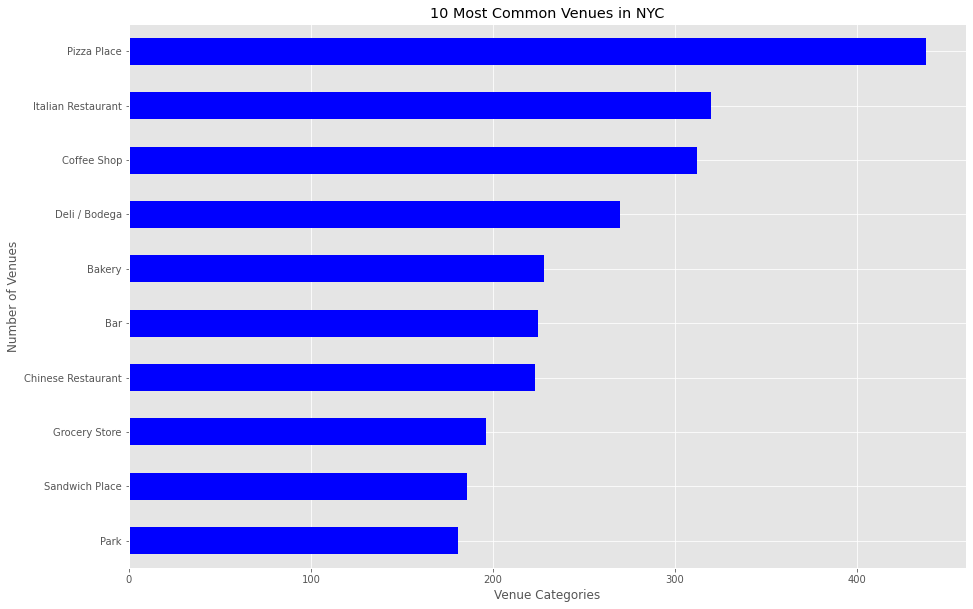

In [90]:
nyc_venues['venue_category'].value_counts(normalize=False).head(10).sort_values(ascending=True).plot(kind='barh', color='blue', figsize=(15, 10))
plt.title("10 Most Common Venues in NYC")
plt.xlabel("Venue Categories")
plt.ylabel("Number of Venues")

#### 10 Most Common Venues in London

Text(0, 0.5, 'Number of Venues')

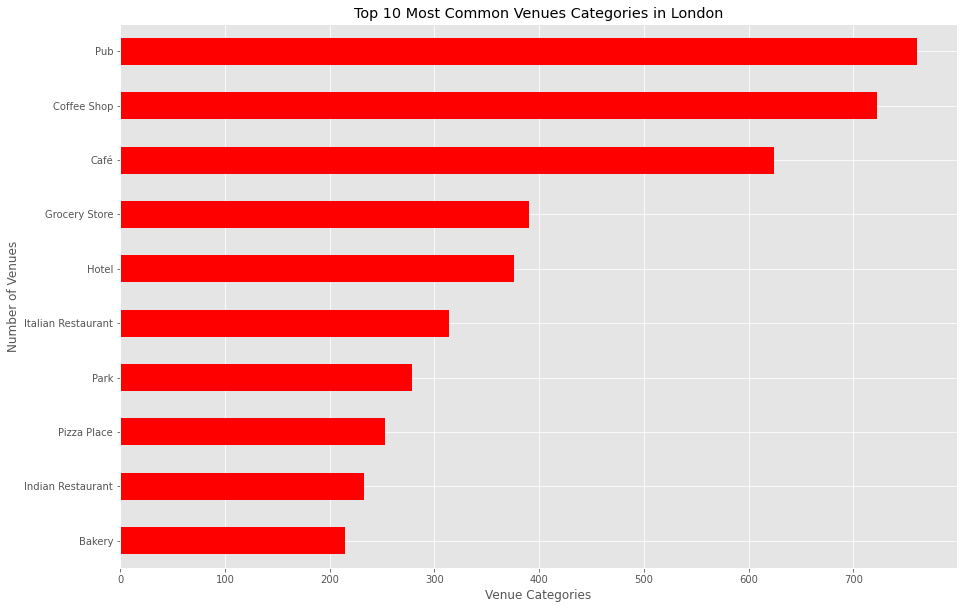

In [91]:
london_venues['venue_category'].value_counts(normalize=False).head(10).sort_values(ascending=True).plot(kind='barh', color='red', figsize=(15, 10))
plt.title("Top 10 Most Common Venues Categories in London")
plt.xlabel("Venue Categories")
plt.ylabel("Number of Venues")

### Join the NYC and London dataframes to apply *K*means

Insert column 'city' to the dataframes

In [92]:
nyc_grouped.insert(0, 'city', 'NYC')
london_grouped.insert(0, 'city', 'London')

In [93]:
df_grouped_joined = pd.concat([nyc_grouped, london_grouped], ignore_index=True).fillna(0)

print(df_grouped_joined.shape)
df_grouped_joined.head()

(822, 521)


,city,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,N

Get the Top 10 venues per neighbohood

In [94]:
neighborhoods_venues_sorted = top_venues_neighboorhood(num_venues=10, city_grouped=df_grouped_joined.iloc[:, 1:])
neighborhoods_venues_sorted.insert(0, 'city', df_grouped_joined['city'])

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(822, 12)


,city,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,NYC,Allerton,Pizza Place,Discount Store,Supermarket,Deli / Bodega,Chinese Restaurant,Spa,Pharmacy,Cosmetics Shop,Gas Station,Spanish Restaurant
1,NYC,Annadale,Pizza Place,American Restaurant,Diner,Park,Train Station,Deli / Bodega,Dance Studio,Food,Restaurant,Gluten-free Restaurant
2,NYC,Arden Heights,Pharmacy,Deli / Bodega,Bus Stop,Coffee Shop,Pizza Place,Zoo Exhibit,Greek Restaurant,Gym / Fitness Center,Gym,Grocery Store
3,NYC,Arlington,Home Service,Bus Stop,Deli / Bodega,Grocery Store,Boat or Ferry,Coffee Shop,Go Kart Track,Golf Course,Gymnastics Gym,Greek Restaurant
4,NYC,Arrochar,Bus Stop,Deli / Bodega,Italian Restaurant,Hotel,Beach,Bagel Shop,Food Truck,Outdoors & Recreation,Pharmacy,Athletics & Sports


### Cluster Neighborhoods 

In [95]:
# set number of clusters
kclusters = 5

joined_clustering = df_grouped_joined.iloc[:, 2:]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=42).fit(joined_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 2, 2, 4, 2, 2, 2, 2, 2, 2], dtype=int32)

In [96]:
# add clustering labels
df_grouped_joined.insert(2, 'cluster_labels', kmeans.labels_)
neighborhoods_venues_sorted.insert(2, 'cluster_labels', kmeans.labels_)

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted.head()

(822, 13)


,city,neighborhood,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,NYC,Allerton,2,Pizza Place,Discount Store,Supermarket,Deli / Bodega,Chinese Restaurant,Spa,Pharmacy,Cosmetics Shop,Gas Station,Spanish Restaurant
1,NYC,Annadale,2,Pizza Place,American Restaurant,Diner,Park,Train Station,Deli / Bodega,Dance Studio,Food,Restaurant,Gluten-free Restaurant
2,NYC,Arden Heights,2,Pharmacy,Deli / Bodega,Bus Stop,Coffee Shop,Pizza Place,Zoo Exhibit,Greek Restaurant,Gym / Fitness Center,Gym,Grocery Store
3,NYC,Arlington,4,Home Service,Bus Stop,Deli / Bodega,Grocery Store,Boat or Ferry,Coffee Shop,Go Kart Track,Golf Course,Gymnastics Gym,Greek Restaurant
4,NYC,Arrochar,2,Bus Stop,Deli / Bodega,Italian Restaurant,Hotel,Beach,Bagel Shop,Food Truck,Outdoors & Recreation,Pharmacy,Athletics & Sports


In [97]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster_labels'] == 0, neighborhoods_venues_sorted.columns[[0, 1] + list(range(3, neighborhoods_venues_sorted.shape[1]))]]

,city,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,NYC,Battery Park City,Park,Hotel,Coffee Shop,Gym,Memorial Site,Food Court,Shopping Mall,Gourmet Shop,Burger Joint,Pizza Place
17,NYC,Bedford Stuyvesant,Coffee Shop,Café,Bar,Pizza Place,BBQ Joint,Bagel Shop,Wine Shop,Wine Bar,Fried Chicken Joint,Deli / Bodega
43,NYC,Carnegie Hill,Coffee Shop,Café,Bookstore,Yoga Studio,Italian Restaurant,Wine Shop,French Restaurant,Gym / Fitness Center,Gym,Pizza Place
49,NYC,Chelsea,Coffee Shop,Art Gallery,American Restaurant,Bakery,Ice Cream Shop,Park,Italian Restaurant,Cycle Studio,Hotel,Cupcake Shop
53,NYC,Civic Center,Gym / Fitness Center,Coffee Shop,Spa,Cocktail Bar,Hotel,French Restaurant,American Restaurant,Italian Restaurant,Park,Bakery
57,NYC,Clinton,Theater,Italian Restaurant,Gym / Fitness Center,American Restaurant,Sandwich Place,Gym,Coffee Shop,Cocktail Bar,Hotel,Spa
62,NYC,Concord,Italian Restaurant,Coffee Shop,Bagel Shop,Grocery Store,Deli / Bodega,Gym / Fitness Center,Peruvian Restaurant,High School,Herbs & Spices Store,Gay Bar
95,NYC,Financial District,Coffee Shop,Cocktail Bar,Park,Hotel,Pizza Place,Gym,Salad Place,Bar,Café,American Restaurant
135,NYC,Hudson Yards,Italian Restaurant,Hotel,Gym / Fitness Center,American Restaurant,Park,Café,Dog Run,Boat or Ferry,Thai Restaurant,Nightclub
137,NYC,Hunters Point,Café,Italian Restaurant,Coffee Shop,Japanese Restaurant,Asian Restaurant,Gym / Fitness Center,Bar,Deli / Bodega,Wine Bar,Brewery


In [119]:
# Compute Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity

nyc_london_cluster1 = df_grouped_joined.copy()
nyc_london_cluster1 = nyc_london_cluster1.loc[neighborhoods_venues_sorted['cluster_labels'] == 0]

# cluster1_similarity = nyc_london_cluster1.iloc[:, :2]
# cluster1_similarity
nyc_london_cluster1.head()

,city,neighborhood,cluster_labels,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit

In [167]:
nyc_london_cluster1.iloc[0, 3:].reshape(1, -1)
# print(kmeans.cluster_centers_[0][:3])

AttributeError: 'Series' object has no attribute 'reshape'

In [158]:
# kmeans.cluster_centers_[0].reshape(-1, 1)

In [172]:
cosine_similarity(nyc_london_cluster1.iloc[0, 3:].values.reshape(1, -1), kmeans.cluster_centers_[0].reshape(1, -1))

array([[0.48840138]])

In [173]:
def similarity_from_centroid(row, centroid):
    return cosine_similarity(np.array(row.iloc[3:]).reshape(1, -1), centroid.reshape(1, -1))

In [197]:
index = nyc_london_cluster1.apply(similarity_from_centroid, centroid=kmeans.cluster_centers_[0], axis=1).sort_values(ascending=False).index

In [201]:
df_grouped_joined.iloc[index, :2].groupby('city').count()

,neighborhood
city,
London,284
NYC,33


* Compare the neighboorhoods that are more similar to each other between NYC and London
* Compare the official borough classification with kmeans classification 

Cluster 2

In [202]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster_labels'] == 1, neighborhoods_venues_sorted.columns[[0, 1] + list(range(3, neighborhoods_venues_sorted.shape[1]))]].iloc[:, :2].groupby('city').count()

,neighborhood
city,
London,47
NYC,9


In [206]:
neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['cluster_labels'] == 4, neighborhoods_venues_sorted.columns[[0, 1] + list(range(3, neighborhoods_venues_sorted.shape[1]))]].iloc[:, :2].groupby('city').count()

,neighborhood
city,
London,74
NYC,10


* London has far more neighborhoods so there are always more london neighborhoods in each cluster
* 

Let's use the PCA algorithm to minimize each neighborhood dimensions so we can plot a graph in 2 dimensions to easily compare them.

In [103]:
nyc_grouped.head()

,neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Terminal,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Church,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Basketball Court,College Bookstore,College Cafeteria,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Multiplex,Museum,Music School,Music Store,Music Venue,Nail Salon,Neighborhood,New American Restaurant,Newsstand,Nightclub,Nightlife Spot,Non-Profit,Noodle House,North 

In [105]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principal_components = pca.fit_transform(nyc_grouped.iloc[:, 1:])

df_nyc_pca = pd.DataFrame(data=principal_components, columns=['pc1', 'pc2'])
df_nyc_pca.insert(0, 'neighborhood', nyc_grouped['neighborhood'])

df_nyc_pca.head()

,neighborhood,pc1,pc2
0,Allerton,-0.040814,-0.030186
1,Annadale,0.045538,-0.019597
2,Arden Heights,-0.071282,-0.004170
3,Arlington,-0.033144,0.032716
4,Arrochar,-0.036126,0.062299
